## INTRODUCTION
eBay Kleinanzeigen is an Online Classified Advertisement Market in Germany. The Dataset contains over 370,000 used Cars scraped from the site

https://www.kaggle.com/orgesleka/used-cars-database

**SECTION 1: DATA IMPORT & CLEANING**
<br>
1.1. Data Import and Understanding
<br>
1.2. Data Cleaning & Transformations
<br>
1.3. Dropping Unused Columns
<br>
1.4. Dataset Shape after Cleaning


**SECTION 2 : EXPLORATORY ANALYSIS** 
<br>
2.1. GroupBy to understand Vehicle Types
<br>
2.2. Correlations between Numeric Features
<br>
2.3. Categorical Data Distributions
<br>
2.4. Plotting Multiple Groups with Facets

**SECTION 3: DATA ANALYSIS**
<br>
3.1. Analysis of Car Brands with Highest Web Ad at eBay Kleinanzeigen for Resale (Top 02 Brands)
<br>
3.2. Analysis of Volkswagen Cars
<br>
3.3. Analysis of BMW Cars

**SECTION 4: DATA PREPARATION FOR MACHINE LEARNING MODELING**
<br>
4.1. Label Encoding for Categorical Variables
<br>
4.2. Feature Scaling


**SECTION 5: MACHINE LEARNING MODELS IMPLEMENTATION**
<br>
5.1. Describing Features and Target
<br>
5.2. Linear Regression as Benchmark Model
<br>
5.3. Regression Models Implementation
<br>
5.4. Properties of Trained Regression Algorithms
<br>
5.5. Performance Plot of Regression Models
<br>
5.6. RandomizedSearchCV for Hyperparameters Tuning
<br>
5.7. Feature Importance Understanding

# SECTION 1 : CLEANING

## 1.1.  Data Import and Understanding

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
%matplotlib inline

In [2]:
df=pd.read_excel('autos.xlsx')
df.head(3)

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480.00,test,NaN,1993.00,manuell,0.00,golf,150000.00,0.00,benzin,volkswagen,NaN,2016-03-24,0.00,70435.00,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300.00,test,coupe,2011.00,manuell,190.00,NaN,125000.00,5.00,diesel,audi,ja,2016-03-24,0.00,66954.00,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800.00,test,suv,2004.00,automatik,163.00,grand,125000.00,8.00,diesel,jeep,NaN,2016-03-14,0.00,90480.00,2016-04-05 12:47:46


In [3]:
df.shape
print ("Used cars dataset has {} data points with {} variables.".format(*df.shape))

Used cars dataset has 371539 data points with 20 variables.


In [4]:
df.describe()
#descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
count,371538.00,371537.00,371538.00,371538.00,371537.00,371537.00,371537.00
mean,17295.44,2004.58,115.55,125617.94,5.73,0.00,50820.67
std,3587905.48,92.87,192.14,40113.10,3.71,0.00,25799.08
min,0.00,1000.00,0.00,5000.00,0.00,0.00,1067.00
25%,1150.00,1999.00,70.00,125000.00,3.00,0.00,30459.00
50%,2950.00,2003.00,105.00,150000.00,6.00,0.00,49610.00
75%,7200.00,2008.00,150.00,150000.00,9.00,0.00,71546.00
max,2147483647.00,9999.00,20000.00,150000.00,12.00,0.00,99998.00


**Analysis:**  From the descriptive statistics it is clear that price, kilometers, registration year and power have very large &  anomalous values which needs to be removed. The mean values are influenced by these Outliers

In [5]:
print("1. Count of New Model Cars of Year 2017: %d" % df.loc[df.yearOfRegistration >= 2017].count()['name'])
print("2. Count of Old Model Cars before year 1960: %d" % df.loc[df.yearOfRegistration < 1960].count()['name'])
print("3. Count of cheap Priced Cars: %d" % df.loc[df.price < 100].count()['name'])
print("4. Count of expensive Cars: %d" % df.loc[df.price > 150000].count()['name'])
print("5. Count of very less powerPS (Pferdestärke): " , df.loc[df.powerPS < 10].count()['name'])
print("6. Count of high powerPS: " , df.loc[df.powerPS > 10000].count()['name'])

1. Count of New Model Cars of Year 2017: 14680
2. Count of Old Model Cars before year 1960: 540
3. Count of cheap Priced Cars: 13318
4. Count of expensive Cars: 233
5. Count of very less powerPS (Pferdestärke):  41036
6. Count of high powerPS:  46


### 1.1.1. Missing Data

In [6]:
total = df.isnull().sum().sort_values(ascending=False)
percent = ((df.isnull().sum()/df.isnull().count()).sort_values(ascending=False))*100
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data=missing_data.head(5)
missing_data.style.bar('Total', align='mid', color='#d65f5f')

,Total,Percent
notRepairedDamage,72062,19.3955
vehicleType,37870,10.1927
fuelType,33388,8.98641
model,20485,5.51355
gearbox,20210,5.43954


**ANALYSIS:** 

The features of notRepairedDamage has 19% Nulls followed by vehicleType with 10%. Here we will not perform any imputation for his nominal data

## 1.2 Data Cleaning & Transformations

Cleaning the Anomalous Values based on Logical Conditioning.

Keeping cars Registration Year between 1960 & 2017, price between 500 and 12,000 and power between 70 & 700

In [7]:
cars = df[(df.yearOfRegistration <= 2017) 
      & (df.yearOfRegistration >= 1960) 
      & (df.price >= 500) 
      & (df.price <= 120000) 
      & (df.powerPS >= 70) 
      & (df.powerPS <= 700)]

### 1.2.1.  Outliers Check of Price, Registration Year and Kilometer Columns through Distribution Plots

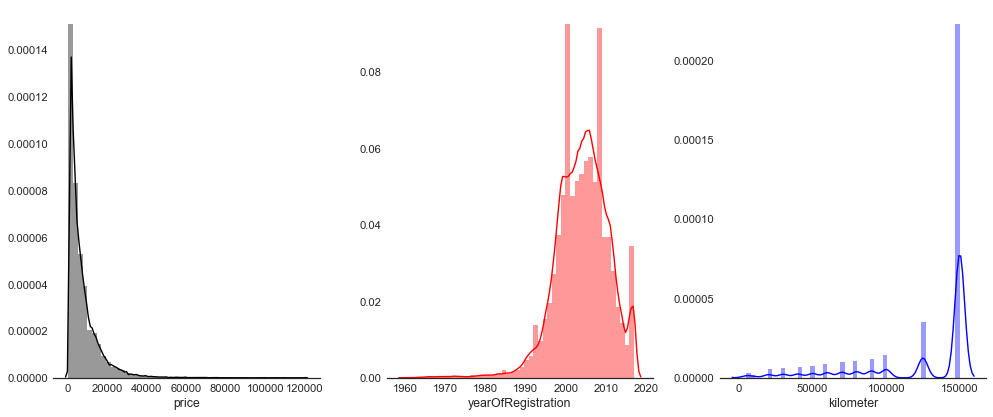

In [8]:
sns.set_style('white')
sns.set_context("paper", font_scale=1.4)  

fig, ax = plt.subplots()

# the size of A4 paper
fig.set_size_inches(14, 6)

plt.subplot(1,3,1)
sns.distplot(cars['price'],color='black');
sns.despine(left=True)

plt.subplot(1,3,2)
sns.distplot(cars['yearOfRegistration'],color='red');
sns.despine(left=True)

plt.subplot(1,3,3)
sns.distplot(cars['kilometer'],color='b');
sns.despine(left=True)
plt.tight_layout()

fig.savefig('output.jpg', format='jpg', dpi=500)

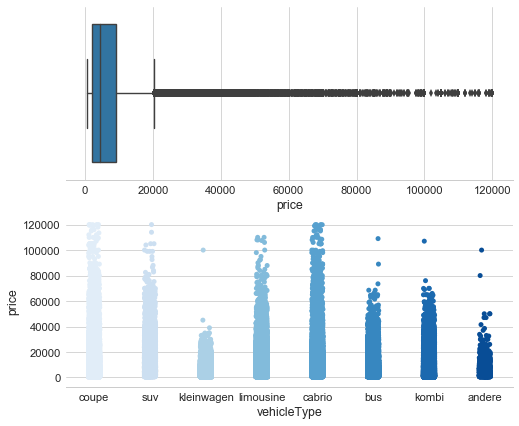

In [9]:
sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1.4)  
fig, ax = plt.subplots()
fig.set_size_inches(8, 7)
#plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
sns.boxplot(x='price', data=cars);
sns.despine(left=True)

plt.subplot(2,1,2)
sns.stripplot(x='vehicleType',y='price', data=cars, jitter=True, palette='Blues')
sns.despine(left=True);

fig.savefig('output.jpg', format='jpg', dpi=500)

**ANALYSIS:** 

1. With this information we can see that the cars prices are skewed right and some outliers lies above ~50, 000. We will eventually want to get rid of outliers to get a normal distribution of this dependent variable for modeling. Box Plot and Strip plot by Vehicle type shows outliers in price

2. Year of registration and kilometers show left skewness. 

### 1.2.2. Log Transformation of Price

In [10]:
cars.loc[:,'price_log'] = np.log1p(cars['price'])
cars=cars[cars['price_log']== np.log1p(cars['price'])]

Skewness after Log: -0.004984
Kurtosis after Log: -0.658253


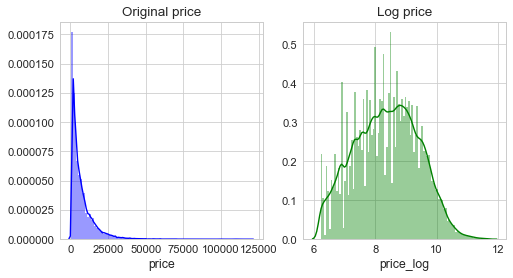

In [11]:
sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1.4)  
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)

#plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.title('Original price')
sns.distplot(cars['price'], color='b', bins=100, hist_kws={'alpha': 0.4});

plt.subplot(1,2,2)
plt.title('Log price')
sns.distplot(cars['price_log'], color='g', bins=100, hist_kws={'alpha': 0.4});

#Skewness and Kurtosis
print("Skewness after Log: %f" % cars['price_log'].skew())
print("Kurtosis after Log: %f" % cars['price_log'].kurt())

fig.savefig('output.jpg', format='jpg', dpi=500)

**ANALYSIS:** 

1. Skewness after log transformation≃0 : If skewness is between -0.5 and 0.5, the distribution is approximately symmetric

2. Kurtosis after log transformation <0: distribution has lighter tails and a flatter peak than the normal distribution. 

### 1.2.3. Subset Observations based on Standard Deviation
Remove Price values more than 03 Standard Deviations from the Mean 

In [12]:
cars=cars[np.abs(cars.price_log-cars.price_log.mean())<=(3*cars.price_log.std())]

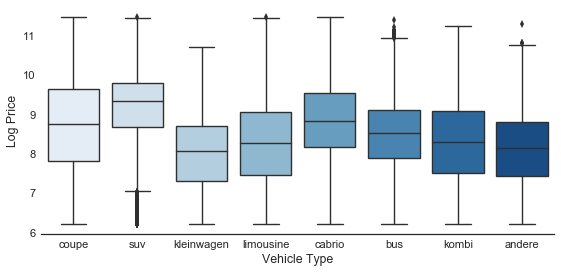

In [13]:
sns.set_style('white')
sns.set_context("paper", font_scale=1.4)  
a=plt.figure(figsize=(8,4))

sns.boxplot(x="vehicleType", y="price_log", data=cars, palette='Blues');
plt.xlabel('Vehicle Type')
plt.ylabel('Log Price')
sns.despine(left=True);
plt.tight_layout() 

a.savefig('output.jpg', format='jpg', dpi=500)

**ANALYSIS:** 

The box plot shows, the price data for various vehicle type doesnot have visible outliers after outliers removal

## 1.3. Dropping Unused Columns

In [14]:
print (cars.seller.value_counts())
print (cars.offerType.value_counts())

privat        260287
gewerblich         1
Name: seller, dtype: int64
Angebot    260287
Gesuch          1
Name: offerType, dtype: int64


In [15]:
cars.drop(['dateCrawled', 'nrOfPictures', 'abtest','lastSeen', 'offerType','seller', 'dateCreated'], axis='columns', inplace=True)

**ANALYSIS:** 

1. Since Seller and offerType columns have only private and Angebot values, thus we can drop these columns. 
2. dateCrawled, nrOfPictures, lastSeen, dateCreated can be dropped as these give no valuable information
3. abtest is an ebay internal variable and can be dropped

In [16]:
# Replacing all the 0 month values to 1
cars.monthOfRegistration.replace(0,1,inplace=True)

# Converting Postal Code to Category
df['postalCode'] = df['postalCode'].astype('category')

# Converting values in columns 'notRepairedDamage', 'gearbox', 'fuelType'
cars.replace({'notRepairedDamage': {'ja': 'Yes','nein': 'No'}},inplace=True)
cars.replace({'gearbox': {'manuell': 'manual','automatik': 'automatic'}},inplace=True)
cars.replace({'fuelType': {'benzin': 'benzene','andere': 'other','elektro':'electrical','lpg':'gas','cng':'gas'}},inplace=True)

**ANALYSIS:** 

1. Replaced all the month values from '0' to '1'. 
2. Converting categorical Column values from German to English and setting postal code values as category. 

## 1.4. Dataset Shape after Cleaning

In [17]:
print("After necessary Logical Cleaning & Outlier removal \nPercentage of Data kept for analisys: %d percent of the original set\n" % (100 * cars['name'].count() / df['name'].count()))
print ("Used Cars dataset has {} data points with {} variables".format (*cars.shape))

After necessary Logical Cleaning & Outlier removal 
Percentage of Data kept for analisys: 70 percent of the original set

Used Cars dataset has 260288 data points with 14 variables


**ANALYSIS:** 

With this information we can see that after necessary logical cleaning and outlier removal we retained 70% of the dataset

# SECTION 2

## Exploratory Data Analysis

### 2.1 Groupby to Understand Vehicle Types

In [18]:
cars.groupby('vehicleType').price.agg(['count','max','mean'])

,count,max,mean
vehicleType,,,
andere,1886,80000.00,5284.79
bus,25968,89000.00,7167.35
cabrio,19933,95400.00,10516.96
coupe,16077,95000.00,11083.03
kleinwagen,29999,45000.00,4431.95
kombi,58406,75990.00,6322.10
limousine,81719,95000.00,6472.30
suv,13299,94900.00,13670.58


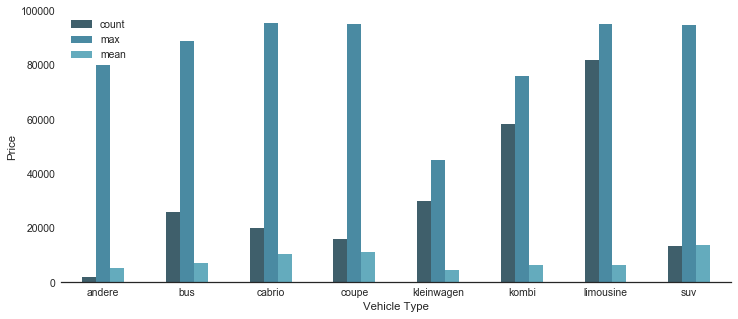

In [19]:
sns.set_style('white')
sns.set_palette("GnBu_d",4,0.8)
sns.set_context("paper", font_scale=1.3) 

cars.groupby('vehicleType').price.agg(['count','max','mean']).plot(kind='bar', figsize=(12,5));
plt.xlabel('Vehicle Type')
sns.despine(left=True)
plt.ylabel('Price')
plt.xticks(rotation='horizontal')

plt.savefig('output.jpeg', dpi=300)

### 2.2 Correlations between Numeric Features

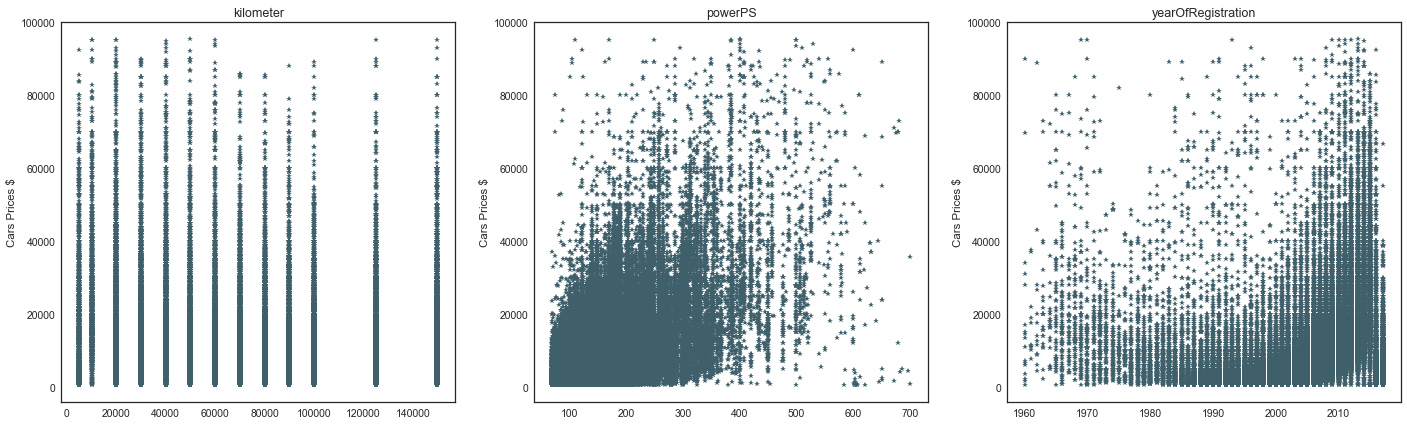

In [20]:
#Correlation of features with the target Price
price1=cars.price
features=cars.loc[:,['kilometer', 'powerPS','yearOfRegistration']]
plt.figure(figsize=(24, 7)) #Figure Size with subplots
for i, col in enumerate(features.columns):
    plt.subplot(1, 3, i+1) #Subplot of 1 row and 03 columns
    plt.plot(features[col], price1, '*')
    plt.title(col)
    plt.ylabel('Cars Prices $')

plt.savefig('output.jpeg', dpi=200)

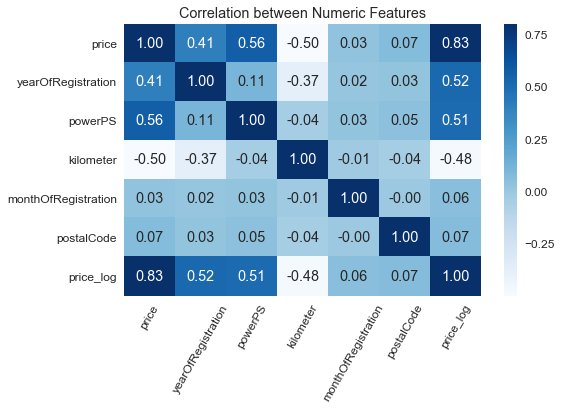

In [21]:
sns.set_style('white')
sns.set_context("paper", font_scale=1.8)  

corr = cars.corr()
corr.loc[:,'price'].abs().sort_values(ascending=False)[1:]
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(8,5))
a = sns.heatmap(corr, annot=True, fmt='.2f' ,vmax=.8, 
                linecolor="white", cmap="Blues")
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=60)
plt.title('Correlation between Numeric Features');

plt.savefig('output.jpeg', dpi=400)

**ANALYSIS:** 

1. Price has a correlation of 0.56 with power and 0.41 with Year of Registration. With increase in Power and year of registration (new cars) price increases.

2. Price has a negative correlation of 0.50 with mileage (kms)

### 2.3. Visualizing Categorical Data Distributions

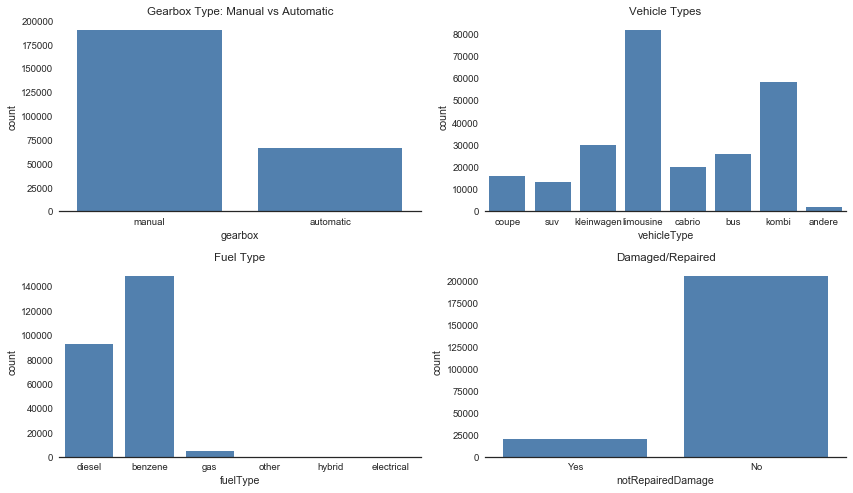

In [22]:
sns.set_style('white')
sns.set_context("paper", font_scale=1.2)  
plt.figure(figsize=(12,7))

plt.subplot(2,2,1)
sns.countplot(cars['gearbox'],color='#4d80b3', saturation=0.90)
plt.title('Gearbox Type: Manual vs Automatic')
plt.tight_layout()
sns.despine(left=True)

plt.subplot(2,2,2)
sns.countplot(cars['vehicleType'],color='#4d80b3', saturation=0.90)
plt.title('Vehicle Types')
plt.tight_layout()
sns.despine(left=True)

plt.subplot(2,2,3)
sns.countplot(cars['fuelType'],color='#4d80b3', saturation=0.90)
plt.title('Fuel Type')
plt.tight_layout()
sns.despine(left=True)

plt.subplot(2,2,4)
sns.countplot(cars['notRepairedDamage'],color='#4d80b3', saturation=0.90)
plt.title('Damaged/Repaired')
plt.tight_layout()
sns.despine(left=True)

plt.savefig('output.jpeg', dpi=400)

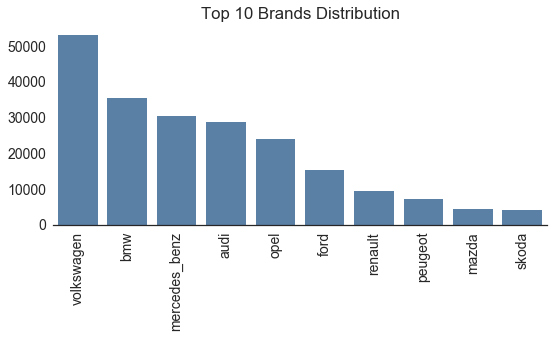

In [23]:
top=cars['brand'].value_counts()[:10]
sns.set_context("notebook", font_scale=1.4, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(8,5))
plt.title('Top 10 Brands Distribution')
g=sns.barplot(top.index, top.values, color='#4d80b3');
plt.xticks(rotation='vertical')
plt.tight_layout()
sns.despine(left=True)

plt.savefig('output.jpeg', dpi=400)

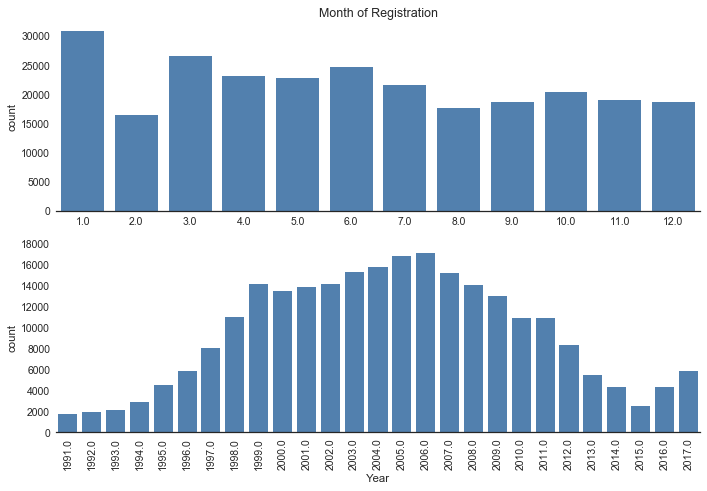

In [24]:
plt.figure(figsize=(10,7))
sns.set_context("paper", font_scale=1.3)  
plt.subplot(2,1,1)
plt.title('Month of Registration')
ax=sns.countplot(cars['monthOfRegistration'],color='#4d80b3', saturation=0.90);
ax.set_xlabel('')
plt.tight_layout()
sns.despine(left=True)

plt.subplot(2,1,2)
reg=cars[cars['yearOfRegistration']>1990]['yearOfRegistration']
g=sns.countplot(reg,color='#4d80b3', saturation=0.90);
rotg = g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.xlabel('Year')
plt.tight_layout()
sns.despine(left=True)
plt.savefig('output.jpeg', dpi=400)

**ANALYSIS**
1. Most of the cars in our dataset have Manual transmission
2. Limousine,Kombi, and Kleinwagen & bus are the most common vehicle types
3. Diesel and benzene are the major fuel used
4. There are less damaged/Repaired vehicles in our dataset
5. Volkswagen,BMW and Mercedes-Benz are the most advertised brands for resale
6. Months of January, March and June are recorded with highest cars registration
7. Most cars in dataset have years of registration between 1998 and 2012

### 2.4. Plotting Multiple Groups with Facets
FacetGrid of Price w.r.t Vehicle Type and Gearbox. Hue shows Repair/Damage

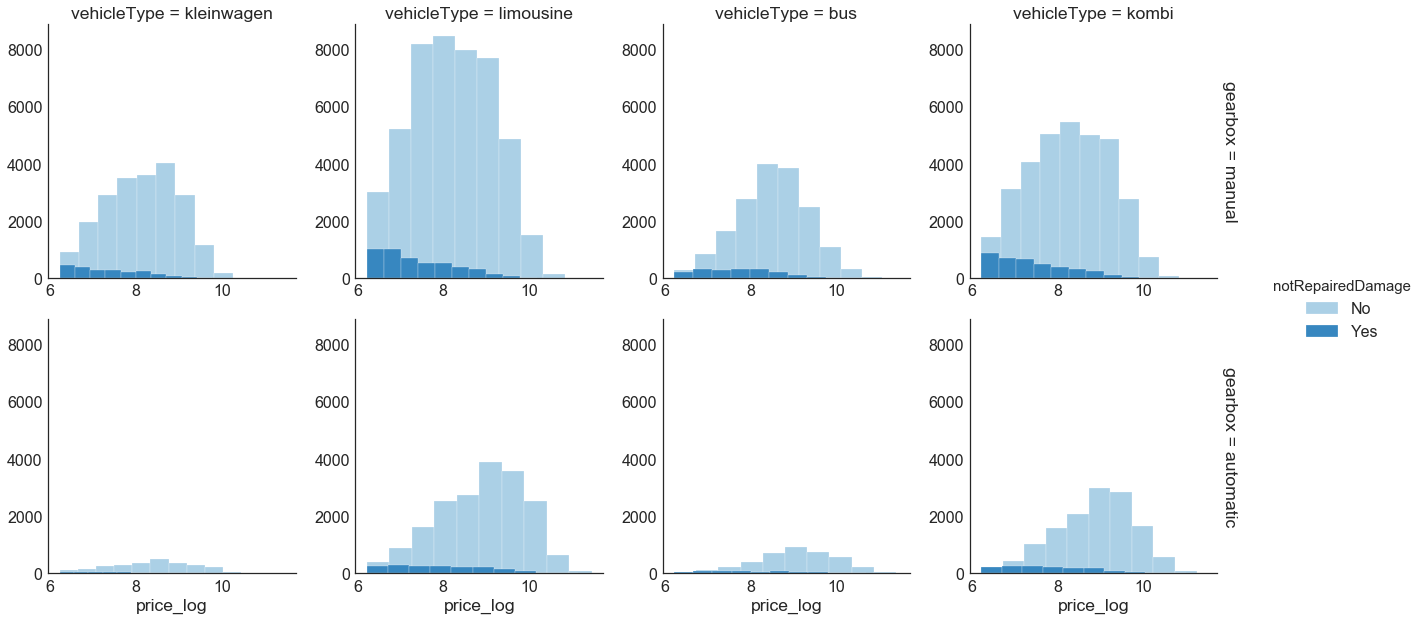

In [27]:
sns.set_context("paper", font_scale=2)  
cars1=cars[cars['vehicleType'].isin
    (['limousine','kombi','kleinwagen', 'bus'])];


g = sns.FacetGrid(cars1, col="vehicleType",  row="gearbox", 
                  hue= 'notRepairedDamage', margin_titles=True, 
                  size=4.5,aspect=1, palette="Blues");
g = g.map(plt.hist, 'price_log', edgecolor="w");
plt.tight_layout()
g.add_legend()
g.savefig('output.jpeg', dpi=400)

**ANALYSIS**

1. Price of Damaged vehicles is less than 'not damaged vehicle'. 
2. Vehicle type Limousine with manual gearbox has highest price, followed by kombi manual gearbox and limousine with automatic gearbox

##  SECTION 3 : DATA ANALYSIS

### 3.1. Analysis of Car Brands with Highest Web Advertisement for Resale (Top 02 Brands)

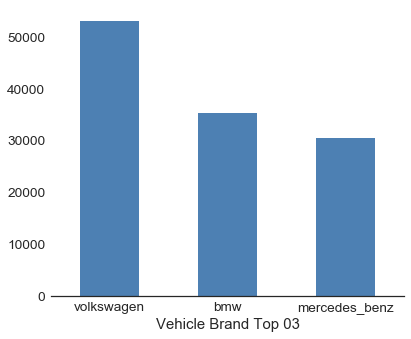

In [28]:
sns.set_context("paper", font_scale=1.7)  
plt.figure(figsize=(6,5))
cars['brand'].value_counts()[:3].plot(kind='bar', color='#4d80b3');
plt.xlabel('Vehicle Brand Top 03')
sns.despine(left=True)
plt.xticks(rotation='horizontal')
plt.tight_layout()
plt.savefig('output.jpeg', dpi=400)

**ANALYSIS**

Volkswagen, BMW and Mercedez Benz are the most advertised cars. For our analysis, we will analyze top 02 brands, Volkswagen and BMW

In [29]:
cars_top=cars.loc[cars['brand'].isin(['volkswagen', 'bmw'])]

In [30]:
ct=pd.crosstab([cars_top.brand, cars_top.gearbox], cars_top.vehicleType)
cm = sns.light_palette("green", as_cmap=True)
ct = ct.style.background_gradient(cmap=cm)
ct

**ANALYSIS**

Volkswagen and BMW cars models with manual transmission are higher in number for resale then automatic transmission. However, only SUVs of both brands with automatic transmission are more in number for resale in our dataset then manual transmission.

In [31]:
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( df[ var ].min() , df[ var ].max() ) )
    facet.add_legend()

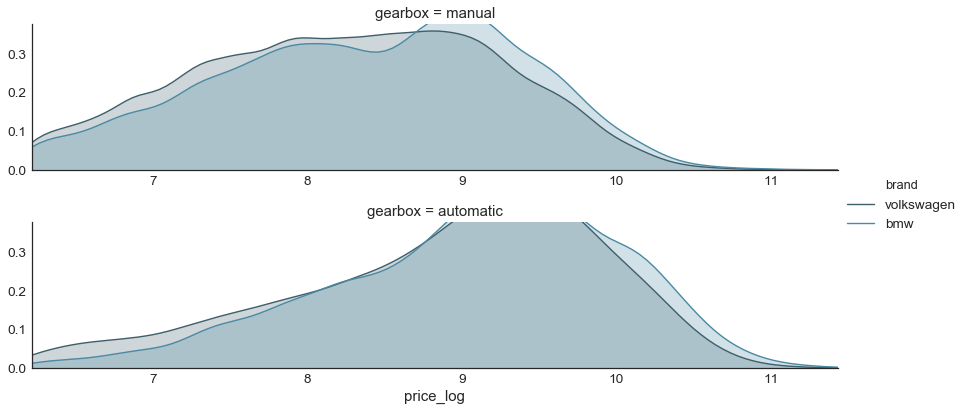

In [32]:
# Plot distributions 
sns.set_context("paper", font_scale=1.7)  
plot_distribution(cars_top , var = 'price_log' , target = 'brand' , row = 'gearbox', palette="husl")
plt.savefig('output.jpeg', dpi=400)

**ANALYSIS**

BMW Cars, both manual and automatic have slightly higher prices for various models as compared to Volkswagen Cars.

### 3.1.1. Price Distribution of Volkswagen & BMW

Maximum Price of Car Models
brand
bmw          92500.00
volkswagen   79499.00
Name: price, dtype: float64
brand
bmw          8533.08
volkswagen   6638.24
Name: price, dtype: float64


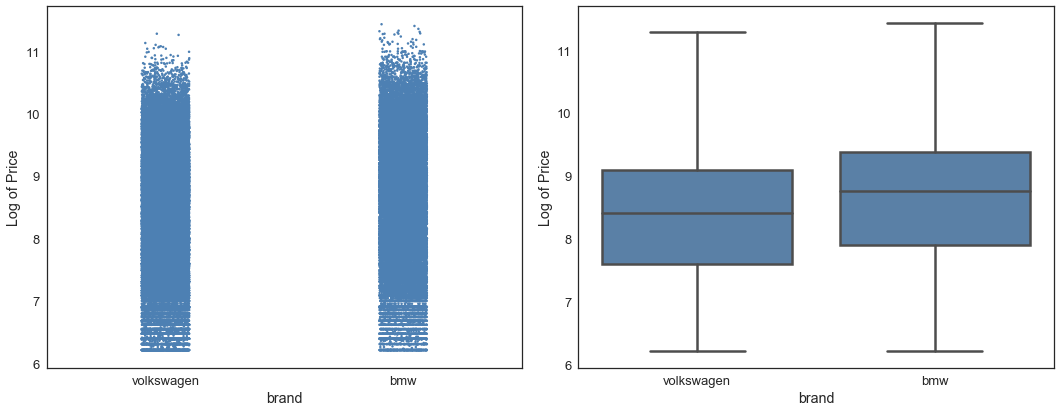

In [97]:
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
g=sns.stripplot(x="brand", y="price_log",data=cars_top,color='#4d80b3', size=2.5, jitter=True);
plt.ylabel('Log of Price')
plt.tight_layout()

plt.subplot(1,2,2)
sns.boxplot(x="brand", y="price_log", data=cars_top, color='#4d80b3');
plt.ylabel('Log of Price')
plt.tight_layout()

print ('Maximum Price of Car Models')
print (cars_top.groupby(by='brand').max()['price'])
print (cars_top.groupby(by='brand').std()['price'])

plt.savefig('output.jpeg', dpi=400)

**ANALYSIS**

Maximum and Median Price of BMW models is higher than Volkswagen with a higher variation in price. 

## 3.2. Analysis of Volkswagen Cars

#### 3.2.1 Factor Plot of Car Price for Various Models of Volkswagen

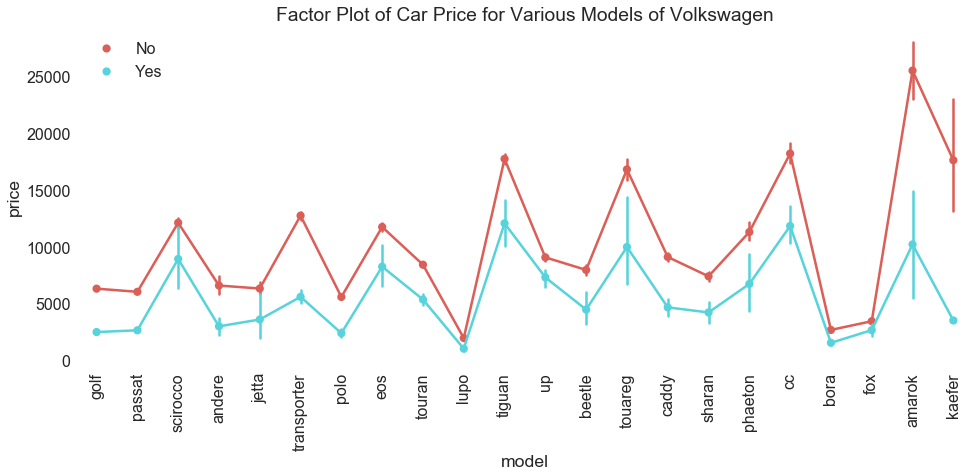

In [34]:
# Using a factor plot 
volkswagen_cars = cars_top[cars_top.brand =='volkswagen']
volkswagen_cars.dropna(subset = ['price'])

sns.set_context("paper", font_scale=2)  

plt1=sns.factorplot('model','price',hue='notRepairedDamage',
                    data=volkswagen_cars, size=7,palette='hls', aspect=2, legend=False);                                                                                                                                                                                                                                                                                                                                             
plt.title('Factor Plot of Car Price for Various Models of Volkswagen')
plt.xticks(rotation=90)                                                               
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper left');
plt.savefig('output.jpeg', dpi=400)

**ANALYSIS**

It can be seen that damaged cars have lower mean price(green color). Volkawagen 'amarok' has highest mean price while volkswagen 'lupo', 'bora' and 'golf' have lowest mean price (Not Damaged)

#### 3.2.2.  Pairplot of Price and Kilometer for Manual & Automatic Transmission Volkswagen Cars

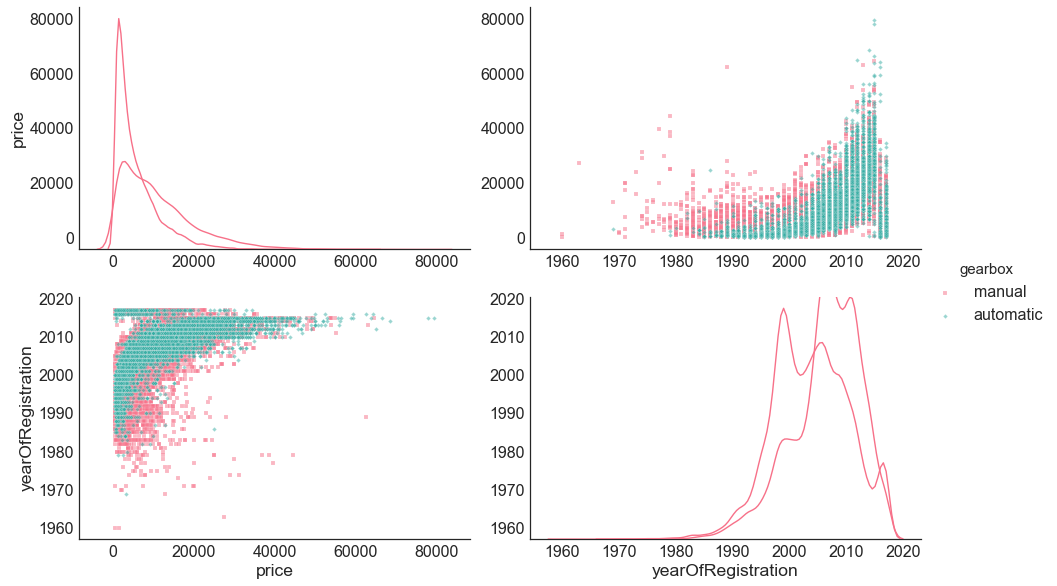

In [35]:
sns.pairplot(volkswagen_cars, vars=['price','yearOfRegistration'], 
              hue='gearbox',size=4.3, aspect=1.5, diag_kind="kde",  markers=["s", "D"],
             palette="husl",plot_kws={'alpha':0.5,"s": 10});

plt.savefig('output.jpeg', dpi=400)

**ANALYSIS**

Manual Volkswagen model cars have earlier years of registration. Automatic Models generally have higher prices.

#### 3.2.3 Most Advertised Volkswagen Locations (Top 04)

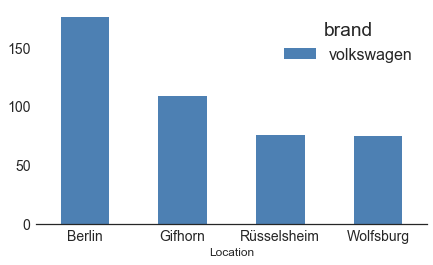

In [36]:
vw=pd.crosstab(volkswagen_cars.brand, volkswagen_cars.postalCode)
vw = vw.sort_values(by='volkswagen', ascending= False, axis=1)
vw.rename(columns={10115.0: 'Berlin', 38518.0: 'Gifhorn',
                  65428.0:'Rüsselsheim',38440.0:'Wolfsburg'},inplace=True)

ax=vw.iloc[:, :4].T.plot(kind='bar',figsize=(7,4),fontsize=14,color='#4d80b3' );
sns.despine(left=True)
ax.set_xlabel("Location",fontsize=12);
plt.xticks(rotation='horizontal')
plt.savefig('output.jpeg', dpi=400)

**ANALYSIS**

Berlin, Gifhorn, Rüsselsheim and Wolfsburg are the top 04 most advertised resale locations

#### 3.2.4. Top 100 Highest and Cheapest Volkswagen Models 

In [37]:
volkswagen100=volkswagen_cars.nlargest(100, 'price', keep='first')
volkswagen_b100=volkswagen_cars.nsmallest(100, 'price', keep='first')

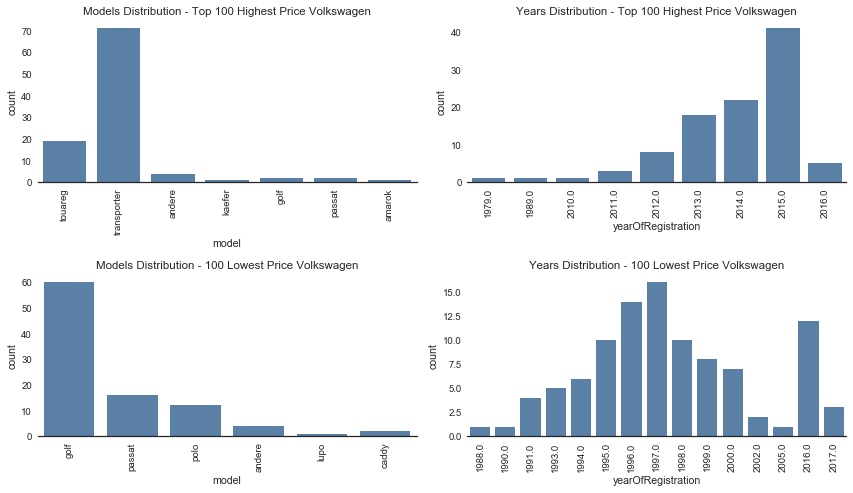

In [38]:
sns.set_style('white')
sns.set_context("paper", font_scale=1.2)   
plt.figure(figsize=(12,7))

plt.subplot(2,2,1)
plt.title('Models Distribution - Top 100 Highest Price Volkswagen')
sns.countplot(volkswagen100['model'],color='#4d80b3')
sns.despine(left=True)
plt.xticks(rotation=90)                                                               
plt.tight_layout() 

plt.subplot(2,2,2)
plt.title('Years Distribution - Top 100 Highest Price Volkswagen')
sns.countplot(volkswagen100['yearOfRegistration'],color='#4d80b3')
sns.despine(left=True)
plt.xticks(rotation=90)  
plt.tight_layout() 

plt.subplot(2,2,3)
plt.title('Models Distribution - 100 Lowest Price Volkswagen')
sns.countplot(volkswagen_b100['model'],color='#4d80b3')
sns.despine(left=True)
plt.xticks(rotation=90)                                                               
plt.tight_layout() 

plt.subplot(2,2,4)
plt.title('Years Distribution - 100 Lowest Price Volkswagen')
sns.countplot(volkswagen_b100['yearOfRegistration'],color='#4d80b3')
sns.despine(left=True)
plt.xticks(rotation=90)                                                               
plt.tight_layout() 

plt.savefig('output.jpeg', dpi=400)

* In top 100 Highest Priced Volkswagen Models transporter & touareg have most occurences and these high priced 100 cars mostly have models between 2011-2016. 
* In bottom 100 Lowest Priced Volkswagen Models golf & passat have most occurences and these lowest priced 100 cars mostly have models between 1991-2000 and 2016 

## 3.3.  Analysis of BMW Cars

#### 3.3.1 Factor Plot of Car Price for Various Models of BMW

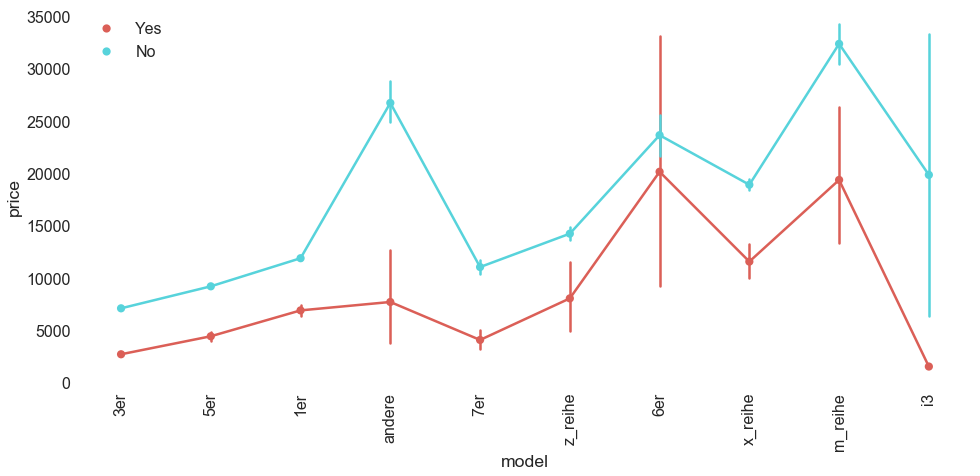

In [39]:
# Using a factor plot 
bmw_cars = cars_top[cars_top.brand =='bmw']
bmw_cars.dropna(subset = ['price'])

sns.set_context("paper", font_scale=2)  

plt1=sns.factorplot('model','price',hue='notRepairedDamage', data=bmw_cars, size=7, palette='hls',aspect=2, legend=False);                                                                                                                                                                                                                                                                                                                                             
plt.xticks(rotation=90)                                                               
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper left');

plt.savefig('output.jpeg', dpi=400)

It can be seen that damaged cars have lower mean price. BMW 'm_reihe' and 'andere' have highest mean price while BMW '3er' and '5er' have lowest (not damaged models)

#### 3.3.2 Pairplot of Price and Kilometer for Manual & Automatic Transmission for BMW Cars

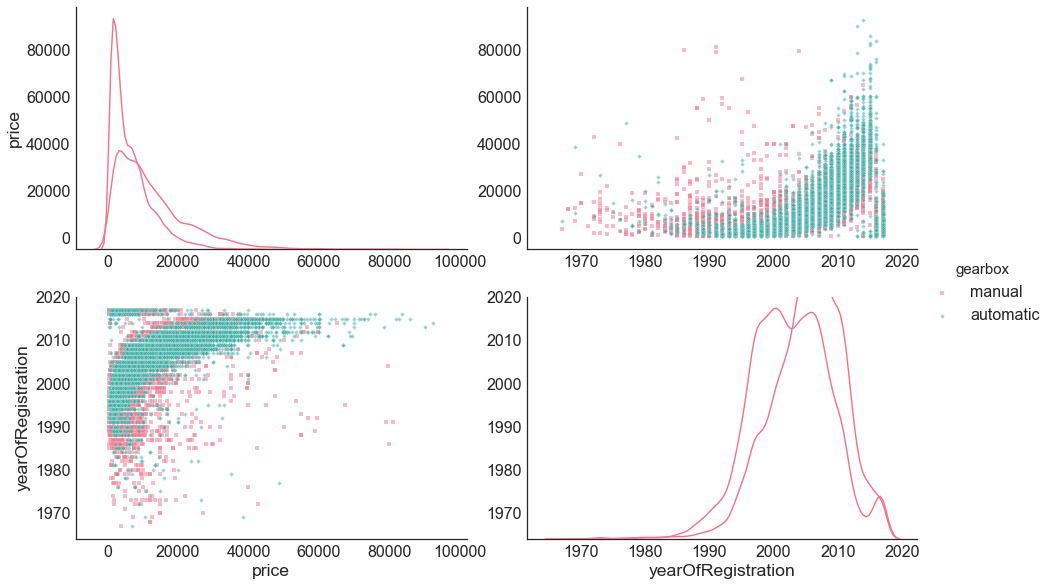

In [40]:
sns.pairplot(bmw_cars, vars=['price','yearOfRegistration'], 
              hue='gearbox',size=4.3, aspect=1.5, diag_kind="kde",  markers=["s", "D"],
             palette="husl",plot_kws={'alpha':0.5,"s": 10});
plt.savefig('output.jpeg', dpi=400)

Manual BMW model cars have earlier years of registration. Automatic Models generally have higher prices then manual.

#### 3.3.3 Most Advertised BMW Car Locations

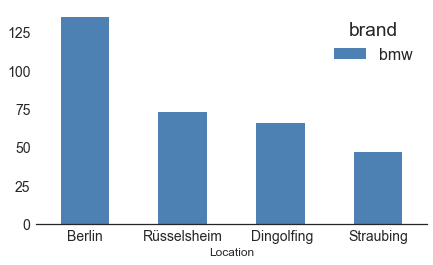

In [41]:
bw=pd.crosstab(bmw_cars.brand, bmw_cars.postalCode)
bw = bw.sort_values(by='bmw', ascending= False, axis=1)
bw.rename(columns={10115.0: 'Berlin', 65428.0:'Rüsselsheim',
                   84130.0: ' Dingolfing',94315.0:'Straubing'},inplace=True)

ax=bw.iloc[:, :4].T.plot(kind='bar',figsize=(7,4),fontsize=14, color='#4d80b3');
sns.despine(left=True)
ax.set_xlabel("Location",fontsize=12);
plt.xticks(rotation='horizontal')
plt.savefig('output.jpeg', dpi=400)

Berlin, Rüsselsheim, Dingolfing and Straubing are the top 04 most advertised resale locations of BMW Cars

#### 3.3.4 Top 100 Highest and Cheapest BMW Models

In [42]:
bmw100=bmw_cars.nlargest(100, 'price', keep='first')
bmw_b100=bmw_cars.nsmallest(100, 'price', keep='first')

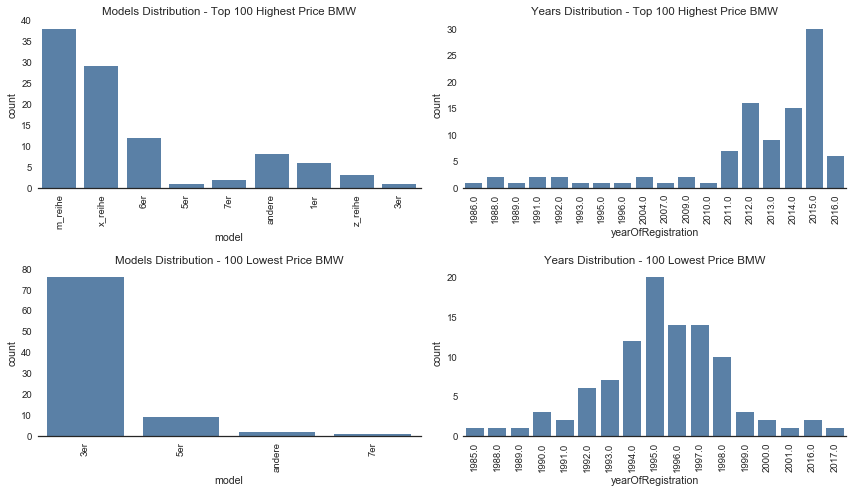

In [43]:
sns.set_style('white')
sns.set_context("paper", font_scale=1.2)   
plt.figure(figsize=(12,7))

plt.subplot(2,2,1)
sns.countplot(bmw100['model'], color='#4d80b3')
plt.title('Models Distribution - Top 100 Highest Price BMW')
sns.despine(left=True)
plt.xticks(rotation=90)                                                               
plt.tight_layout() 

plt.subplot(2,2,2)
sns.countplot(bmw100['yearOfRegistration'], color='#4d80b3')
plt.title('Years Distribution - Top 100 Highest Price BMW')
sns.despine(left=True)
plt.xticks(rotation=90)  
plt.tight_layout() 

plt.subplot(2,2,3)
sns.countplot(bmw_b100['model'], color='#4d80b3')
plt.title('Models Distribution - 100 Lowest Price BMW')
sns.despine(left=True)
plt.xticks(rotation=90)                                                               
plt.tight_layout() 

plt.subplot(2,2,4)
sns.countplot(bmw_b100['yearOfRegistration'], color='#4d80b3')
plt.title('Years Distribution - 100 Lowest Price BMW')
sns.despine(left=True)
plt.xticks(rotation=90)  
plt.tight_layout() 

plt.savefig('output.jpeg', dpi=400)

**ANALYSIS**

* In top 100 Highest Priced BMW Models m_reihe, x_reihe and 6er have most occurences and these top 100 cars mostly have Years of registration between 2011-2015.
* In 100 Lowest Priced BMW Models 3er & 5er have most occurences and these bottom 100 cars mostly have models between 1992-1998

## SECTION 4

##   Data Preparation for Machine Learning Modeling

In [44]:
cars_model=cars.loc[:,['price','vehicleType', 'yearOfRegistration',
                       'gearbox', 'powerPS','kilometer',
                       'monthOfRegistration', 'fuelType', 'brand',
                       'notRepairedDamage', 'price_log']]

cars_model=cars_model.dropna()

## 4.1. Label Encoding for Categorical Variables

Using LabelEncoder to encode categorical features (vehicleType ,gearbox, fuelType, notRepairedDamage and brand) between 0 and n_classes-1. Label Encoder imposes ordinality. The algorithms like decision trees and random forests that can work with categorical variables works well with this. Advantage of using LabelEncoder is that it can be used to store values using less disk space and less features. The disadvantage of using One Hot Encoding is that we will have high cardinality, the feature space will grow up quickly and we may encounter the curse of dimensionality.


In [45]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
le=LabelEncoder()
cat_vars=['vehicleType','gearbox','fuelType',
          'notRepairedDamage','brand']

for col in cat_vars:
    cars_model[col]=le.fit_transform(cars_model[col])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(le_name_mapping)

{'andere': 0, 'bus': 1, 'cabrio': 2, 'coupe': 3, 'kleinwagen': 4, 'kombi': 5, 'limousine': 6, 'suv': 7}
{'automatic': 0, 'manual': 1}
{'benzene': 0, 'diesel': 1, 'electrical': 2, 'gas': 3, 'hybrid': 4, 'other': 5}
{'No': 0, 'Yes': 1}
{'alfa_romeo': 0, 'audi': 1, 'bmw': 2, 'chevrolet': 3, 'chrysler': 4, 'citroen': 5, 'dacia': 6, 'daewoo': 7, 'daihatsu': 8, 'fiat': 9, 'ford': 10, 'honda': 11, 'hyundai': 12, 'jaguar': 13, 'jeep': 14, 'kia': 15, 'lada': 16, 'lancia': 17, 'land_rover': 18, 'mazda': 19, 'mercedes_benz': 20, 'mini': 21, 'mitsubishi': 22, 'nissan': 23, 'opel': 24, 'peugeot': 25, 'porsche': 26, 'renault': 27, 'rover': 28, 'saab': 29, 'seat': 30, 'skoda': 31, 'smart': 32, 'sonstige_autos': 33, 'subaru': 34, 'suzuki': 35, 'toyota': 36, 'volkswagen': 37, 'volvo': 38}


###  4.1.2.  Feature Scaling

'kilometer' has much higher values then numeric column of powerPS and yearOfRegistration, therfore we will scale these columns using MinMaxScaler which essentially shrinks the range, such that the range is now between 0 and 1. If the distribution is not Gaussian as in our case, MinMaxScaler performs well

In [46]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
cars_model[['yearOfRegistration', 'powerPS','kilometer']] = scaler.fit_transform(cars_model[['yearOfRegistration', 'powerPS','kilometer']]);

In [47]:
cars_model.head()

,price,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,price_log
1,18300.00,3,0.89,1,0.19,0.83,5.00,1,1,1,9.81
3,1500.00,4,0.72,1,0.01,1.00,6.00,0,37,0,7.31
5,650.00,6,0.61,1,0.05,1.00,10.00,0,2,1,6.48
6,2200.00,2,0.77,1,0.06,1.00,8.00,0,25,0,7.70
10,2000.00,6,0.77,1,0.06,1.00,12.00,0,19,0,7.60


## SECTION 5

## Machine Learning Models Implementation
### Performance Metric

We will use the coefficient of determination, R2, to quantify Model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions.

### 5.1. Describing Features and Target

In [48]:
seed = 42
np.random.seed(seed)
X=cars_model.iloc[:,1:10] # Input Features
y=cars_model.iloc[:,10] #Response cars price

### 5.1.1. Train Test Split

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

## 5.2. Linear Regression as Benchmark Model

In [50]:
# Initialize and fit the model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# R^2 (coefficient of determination) regression score function
# Mean squared error regression loss

benchmark_model = LinearRegression() #object of class LinearRegression

start = time()
benchmark_model.fit(X_train, y_train) #Fit object to training set
end = time()
y_pred=benchmark_model.predict(X_test)
print("Classifier fitted in {:.2f} seconds".format(end-start))
print("Score on Training data : {:.2f}%".format(benchmark_model.score(X_train, y_train) * 100))
print("Score on Testing data : {:.2f}%".format(benchmark_model.score(X_test, y_test) * 100))
print("RMSE : {:.3f}".format(np.sqrt(np.mean((y_test - y_pred)**2))))

Classifier fitted in 0.05 seconds
Score on Training data : 67.47%
Score on Testing data : 68.01%
RMSE : 0.583


**ANALYSIS**

The benchmark model has R2 Score of 68% on test data set. This score is not that good. Now we will fit a couple of other models and comapre their performance to Benchmark Model

### 5.2.1 Linear Regression Model Coefficients

In [51]:
coeff_df=pd.DataFrame(benchmark_model.coef_,X.columns,columns=['Coefficient'])
coeff_df=coeff_df.transpose #Create a Dataframe from the coefficients
coeff_df()

,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
Coefficient,-0.04,3.50,-0.10,4.56,-1.13,0.00,0.18,0.00,-0.63


## 5.3. Machine Learning Regression Models Implementation

In [52]:
# Function to fit the regressor and record performance metrics
def pipeline(reg, X_train, y_train, X_test, y_test, **kwargs):
    
    # Dictionary to hold properties of Models
    reg_props = {}
    
    # Initialize and fit the regressor, and time taken
    regressor = reg(**kwargs)
    start = time()
    regressor.fit(X_train, y_train)
    end = time()
    
    # Store the metrics for the regressor
    reg_props["name"] = reg.__name__
    reg_props["train_time"] = end - start
    reg_props["train_score"] = regressor.score(X_train, y_train)
    reg_props["test_score"] = regressor.score(X_test, y_test)
    reg_props["rmse"] = np.sqrt(mean_squared_error(y_test, regressor.predict(X_test)))
    
    return reg_props

### 5.3.1. Import Regression Algorithms
1. Ridge Regression
2. K Nearest NeighborsRegressor
3. Random Forest Regression
4. Gradient Boosting Regressor
5. Extra Forest Regressor
6. Multi-layer Perceptron Regressor.

In [66]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor

# Function to execute each algorithm through the pipeline
def execute_pipeline():
    # Create the list of algorithms
    regressors = [
        Ridge,
        KNeighborsRegressor,
        RandomForestRegressor,
        GradientBoostingRegressor,
        MLPRegressor,
        ExtraTreesRegressor,
            ]
    
    # To store the properties for each regressor
    props = []
    
    """
    Iterate thorugh the list of regressors,
    passing each thorugh the pipeline and
    storing its properites
    """ 
    for reg in regressors:
        properites = pipeline(reg, X_train, y_train, X_test, y_test)
        props.append(properites)
        
    return props

Regressor Models Scores Dataframe

In [67]:
def get_properties():
    # Obtain the properties after executing the pipeline
    properties = execute_pipeline()
    
    # Extract each individual property of the Regressors
    names = [prop["name"] for prop in properties]
    train_times = [prop["train_time"] for prop in properties]
    train_scores = [prop["train_score"] for prop in properties]
    test_scores = [prop["test_score"] for prop in properties]
    rmse_vals = [prop["rmse"] for prop in properties]
        
    # Create a DataFrame from these properties
    df = pd.DataFrame(index=names, 
                    data = {
                            "Training Times": train_times,
                            "Training Scores": train_scores,
                            "Testing Scores": test_scores,
                            "RMSE": rmse_vals  
                      }
                  )
    
    return df

# Obain the properties in a structured DataFrame after executing the pipeline
properties = get_properties()

## 5.4.  Properties of Trained Algorithms

In [68]:
# Append the peoperties of Linear Rgression Benchmark model to the DataFrame
# Storing the properties of Selected models

properties = pd.concat(
    [properties,
    pd.Series(
    {
        "Name": "Linear Regression (Benchmark)",
        "RMSE": np.sqrt(mean_squared_error(y_test, benchmark_model.predict(X_test))),
        "Training Scores": benchmark_model.score(X_train, y_train),
        "Testing Scores" :benchmark_model.score(X_test, y_test),
        "Training Times": end - start
        
    }
    ).to_frame().T.set_index(["Name"])]
)

properties

,RMSE,Testing Scores,Training Scores,Training Times
Ridge,0.58,0.68,0.67,0.03
KNeighborsRegressor,0.50,0.76,0.85,4.03
RandomForestRegressor,0.37,0.87,0.96,4.80
GradientBoostingRegressor,0.39,0.86,0.86,16.09
MLPRegressor,0.41,0.85,0.85,54.83
ExtraTreesRegressor,0.38,0.87,0.98,3.65
Linear Regression (Benchmark),0.58,0.68,0.67,0.05


### 5.4.1.  Training Time of Regression Algorithms

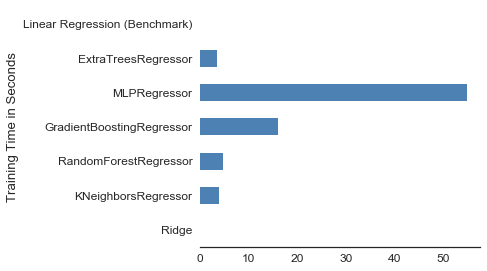

In [108]:
# Plot to compare the training time of algorithms
sns.set_context("notebook", font_scale=1.2)
plt.figure(figsize=(7,4))
plt.ylabel("Training Time in Seconds")
properties["Training Times"].plot(kind="barh", color='#4d80b3');
sns.despine(left=True)
plt.tight_layout()
plt.savefig('output.jpeg', dpi=400)

**ANALYSIS**

1. It can be seen that Multi-layer Perceptron has the highest training time followed by Gradient Boosting Regressor

2. Linear Regression and K Neigbors Regressors took the least amount to train

3. Random Forest and Extra Tree Regressor have moderate training times

## 5.5. Performance Plot of Regression Models

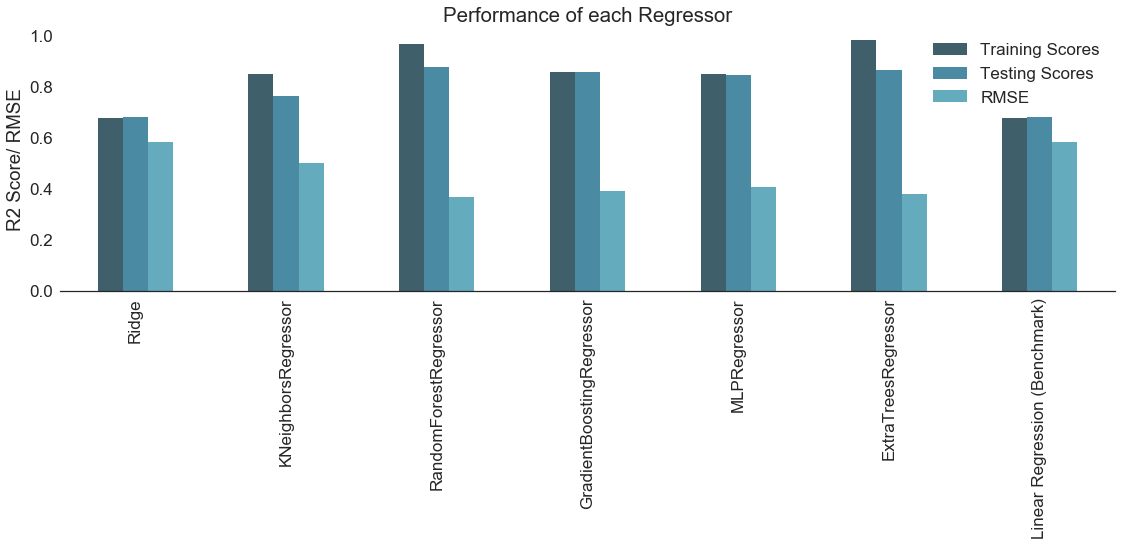

In [110]:
# Plot to compare the performance of Models on both datasets
sns.set_context("notebook", font_scale=1.7)
ax= properties[["Training Scores", "Testing Scores", "RMSE"]].plot(kind="bar", title="Performance of each Regressor", figsize=(16, 8))
ax.set_ylabel("R2 Score/ RMSE");
sns.despine(left=True)
plt.tight_layout()
plt.savefig('output.jpeg', dpi=400)

** ANALYSIS**

1. Random Forest Regressor has lowest RMSE and high R2 score on test set. Thus we select Random Forest Regressor as our final fitted Model. 
2. Although, ExtraTreesRegressor 	has same R2 score on test set, but it has high RMSE and high training score, thus it may overfit

## 5.6. RandomizedSearchCV for Hyperparameters Tuning

In [89]:
from sklearn.model_selection import RandomizedSearchCV

# Initialize the best performing regressor
clf = RandomForestRegressor(random_state=seed)

# Define the parameter subset
param_grid = {
    "n_estimators": [10, 50, 75, 100, 150],
    "max_features": ["auto", "sqrt", "log2"],
    "max_depth": [50, 100,150, 200, 250]
}

# Use Randomized search to try 20 subsets from parameter space with 5-fold cross validation
grid_search = RandomizedSearchCV(clf, param_grid, n_iter=10, scoring="r2", cv=3, n_jobs=-1, verbose=2, random_state=seed)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.6min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [10, 50, 75, 100, 150], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [50, 100, 150, 200, 250]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='r2', verbose=2)

In [90]:
#Display best params
print("Parameters of best Regressor : {}".format(grid_search.best_params_))

Parameters of best Regressor : {'n_estimators': 150, 'max_features': 'sqrt', 'max_depth': 250}


In [91]:
best_model = grid_search.best_estimator_

# Display metrics on training and test set
print("R2 score on Training set = {:.3f}".format(best_model.score(X_train, y_train)))
print("RMSE on Training set = {:.3f}".format(np.sqrt(mean_squared_error(y_train, best_model.predict(X_train)))))
print("R2 score on Testing set = {:.3f}".format(best_model.score(X_test, y_test)))
print("RMSE on Testing set = {:.3f}".format(np.sqrt(mean_squared_error(y_test, best_model.predict(X_test)))))

R2 score on Training set = 0.969
RMSE on Training set = 0.181
R2 score on Testing set = 0.885
RMSE on Testing set = 0.349


**ANALYSIS**

1. GridSearchCV can be computationally expensive, especially if you are searching over a large hyperparameter space and dealing with multiple hyperparameters

2. In contrast RandomizedSearchCV iterates over a random list of parameters. A fixed number of parameter settings is sampled from the specified distributions is tried out. The number of parameter settings that are tried is given by n_iter.

3. Using GridSearchCV we have improved the R2 Score from 0.87 to 0.885 and reduced the RMSE from 0.37 to 0.35

### 5.6.1. Actual vs Predicted Price for Best Parameters Random Forest Model

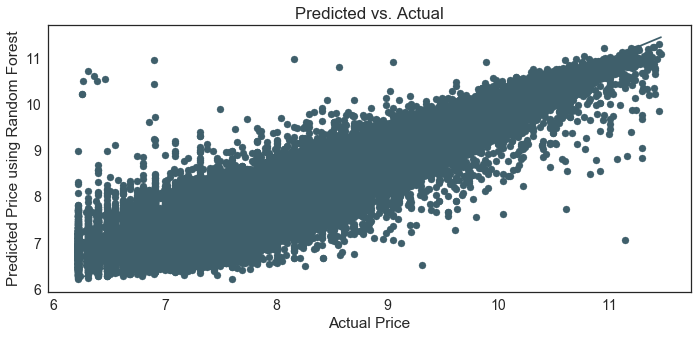

In [64]:
y_pred= best_model.predict(X_test)
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price using Random Forest')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.tight_layout()

In [ ]:
X_test.head(2)
y_test.head(2)

In [65]:
print(best_model.predict([[5,0.84,1,0.13,0.83,1.00,1,24,0]]))

[ 9.02939885]


## 5.7. Features Importance

In [87]:
# Find the index of most and least important feature and display that column
print("Most important feature = {}".format(X_train.columns[np.argmax(best_model.feature_importances_)]))
print("Least important feature = {}".format(X_train.columns[np.argmin(best_model.feature_importances_)]))

# Get the indices based on feature importance in ascending order 
feature_indices = np.argsort(best_model.feature_importances_)

print("\nTop 5 most important features:-")
# Reverse the array to get important features at the beginning
for index in feature_indices[::-1][:5]:
    print(X_train.columns[index])
    
print("\nTop 5 least important features:-")
for index in feature_indices[:5]:
    print(X_train.columns[index])

Most important feature = yearOfRegistration
Least important feature = fuelType

Top 5 most important features:-
yearOfRegistration
powerPS
kilometer
brand
vehicleType

Top 5 least important features:-
fuelType
gearbox
notRepairedDamage
monthOfRegistration
vehicleType


**ANALYSIS**

1. Using Scikit-learn tree-based feature selection, which provides a way to select relevant features using the results from ensemble of decision trees. The top 05 features according to ranking are yearOfRegistration, powerPS, kilometer, brand and vehicleType

2. This method uses all the variables  to  generate  a  model  and  then  analyze  the  model  to  infer  the  importance  of the  variables. Consequently, they directly link variable importance to the learner used to model the relationship

In [48]:
# Plot feature importance
fi = pd.DataFrame(index=X_train.columns[feature_indices], data=np.sort(best_model.feature_importances_))
fi.sort_values(by=0, ascending=False)
fi.head()

,0
fuelType,0.02
gearbox,0.03
notRepairedDamage,0.03
monthOfRegistration,0.03
vehicleType,0.04


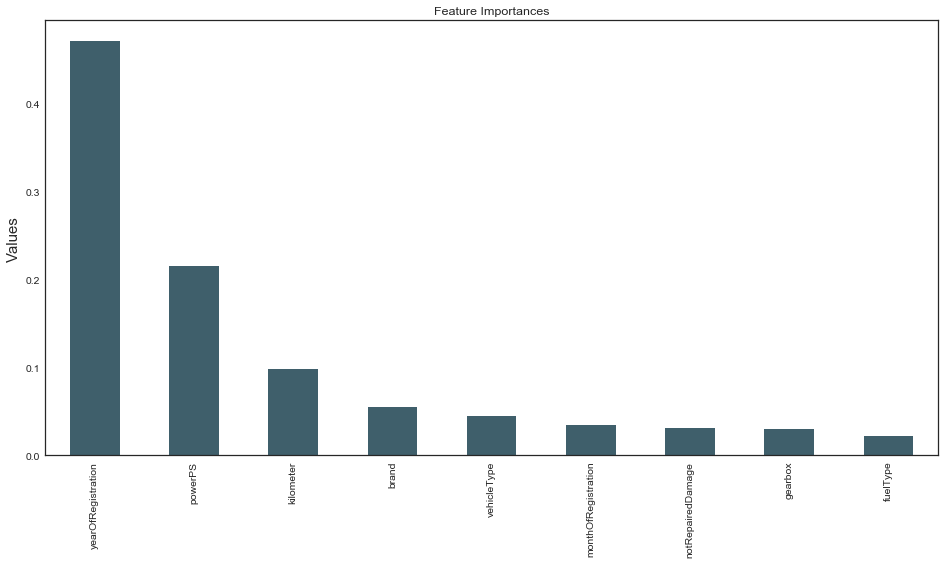

In [49]:
# Plot feature importance
fi = pd.DataFrame(index=X_train.columns[feature_indices], data=np.sort(best_model.feature_importances_))
fi.sort_values(by=0, ascending=False, inplace=True)
ax = fi.plot(kind="bar", title="Feature Importances", figsize=(16, 8))
ax.set_ylabel("Values", fontsize="large")
ax.legend_.remove()

### 5.7.1.  Feature Ranking with Recursive Feature Elimination.

In [50]:
from sklearn.feature_selection import RFE
# Create the RFE object and rank each pixel
clf_rf_3 = RandomForestRegressor()      
rfe = RFE(estimator=clf_rf_3, n_features_to_select=5, step=1)
rfe = rfe.fit(X_train, y_train)
print('Chosen best 5 feature by rfe:',X_train.columns[rfe.support_])

Chosen best 5 feature by rfe: Index(['vehicleType', 'yearOfRegistration', 'powerPS', 'monthOfRegistration',
       'brand'],
      dtype='object')


**ANALYSIS**

1. Recursive Feature Elimination recursively removes features, builds a model using the remaining attributes and calculates model accuracy. 

2. RFE is able to work out the combination of attributes that contribute to the prediction on the target variable. 

3. The top 05 features using RFE are vehicleType', 'yearOfRegistration', 'powerPS', 'monthOfRegistration

### 5.7.2.  Regression Model using StatsModels to understand Model Accuracy and Feature Importance

In [19]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import statsmodels.api as sm
import statsmodels.formula.api as smf
m = smf.ols('price ~  vehicleType + yearOfRegistration + gearbox + powerPS +  kilometer + fuelType+ notRepairedDamage',cars_model).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                 4.915e+04
Date:                Wed, 15 Nov 2017   Prob (F-statistic):               0.00
Time:                        15:39:32   Log-Likelihood:            -2.1250e+06
No. Observations:              213002   AIC:                         4.250e+06
Df Residuals:                  212994   BIC:                         4.250e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           2325.2137    122.699     18.951      0.000    2084.726    2565.701
vehicleType         -253.9913      6.271    -40.504      0.000    -266.282    -241.701
yearOfRegistration  1.493e+04    123.372    121.047      0.000    1.47e+04    1.52e+04
gearbox             -624.8292     29.056    -21.504      0.000    -681.779    -567.880
powerPS             4.502e+04    135.192    333.027      0.000    4.48e+04    4.53e+04
kilometer           -1.22e+04     47.615   -256.285      0.000   -1.23e+04   -1.21e+04
fuelType            1122.6647     19.628     57.197      0.000    1084.194    1161.135
notRepairedDamage  -2327.9686     40.684    -57.221      0.000   -2407.708   -2248.229
==============================================================================
Omnibus:                   156463.841   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7393876.278
Skew:                           3.055   Prob(JB):                         0.00
Kurtosis:                      31.209   Cond. No.                         77.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

** ANALYSIS**

1. p-values of the fitted Regression Model are very small, then it can be accepted that these parameters have a non-zero value and are statistically significant in the model. 

2. Adj. R-squared comes out to be 0.618, which is very low compared to R-squared of our Random Forest Model

3. Based on a Regression Model ,powerPS, kilometer, repair/damaged are the best features to choose depending on the magnitude of coefficients.

4. As we can see, the F-statistic for this model is very high and the associated p-value is negligible, suggesting that the parameter estimates for this model were all significant and non-zero